In [1]:
## this code file was made with the assitance of https://colab.research.google.com/github/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb#scrollTo=mdMyUKPfM2DG

In [2]:
#generic imports
import torch, torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
torch.set_grad_enabled(False);

In [3]:
#functions, from online (https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb)
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):

  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def run_worflow(my_image, my_model):
  img = transform(my_image).unsqueeze(0)

  outputs = my_model(img)

  for threshold in [0.9, 0.7, 0]:
    
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)
    plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled)


In [4]:
#getting directory ready
%cd /content/

#insert detr-master here

#insert Planes-Coco here
!mkdir data

%cd /content/data



/content
/content/data


In [5]:
#unzip the file
# !!! must have manually loaded the zips into proper place
%cd /content/data
!unzip PlanesCoco.zip > /dev/null

/content/data


In [6]:
%cd /content/

!rm -rf detr
!git clone https://github.com/woctezuma/detr.git

%cd detr/

!git checkout finetune

/content
Cloning into 'detr'...
remote: Enumerating objects: 239, done.
remote: Total 239 (delta 0), reused 0 (delta 0), pack-reused 239
Receiving objects: 100% (239/239), 284.62 KiB | 23.72 MiB/s, done.
Resolving deltas: 100% (131/131), done.
/content/detr
Branch 'finetune' set up to track remote branch 'finetune' from 'origin'.
Switched to a new branch 'finetune'


In [7]:
# setting up model
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

first_class_index = 0

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

In [8]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

dataDir='/content/data/custom/'
dataType='train2017'
annFile='{}annotations/custom_train.json'.format(dataDir)

coco=COCO(annFile)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [20]:
#testing to see if needed

cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

#setting image id's
catIds = coco.getCatIds(catNms=['plane']);
imgIds = coco.getImgIds(catIds=catIds );


Categories: ['Planes-in-satellitte', 'plane']
Super-categories: {'none', 'Planes-in-satellitte'}


Image n°79
Image name: /content/data/custom//train2017/img240_png.rf.2f3e3de550e483c00f20cb2886de2001.jpg


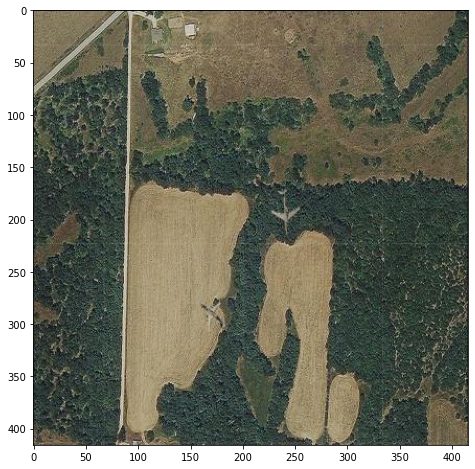

In [10]:
#example image

img_id = imgIds[np.random.randint(0,len(imgIds))]

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

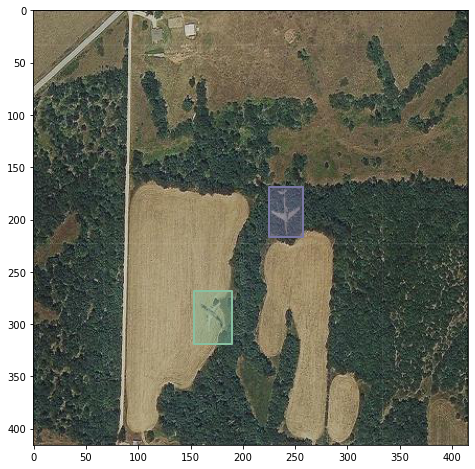

In [11]:
#example image with boxes

annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

# load and display instance annotations
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

In [19]:
if first_class_index == 0:

  num_classes = 1

  finetuned_classes = [
      'plane',
  ]

else:

  num_classes = 2

  finetuned_classes = [
      'N/A', 'plane',
  ]

print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 0
Parameter num_classes: 1
Fine-tuned classes: ['Planes-in-satellitte']


In [13]:
%cd /content/detr/

/content/detr


In [ ]:
# running the training
# set epoch as needed, currently set to 3 for time

# !!! you need to go to /content/detr/util/misc.py and comment out lines 21, 22, and 23
#                -they are not compatiable with current libraries

In [21]:
!python main.py \
  --dataset_file "custom" \
  --coco_path "/content/data/custom/" \
  --output_dir "outputs" \
  --resume "detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 3

Not using distributed mode
git:
  sha: e42a3b174d2325c28f82d7114138c755ac7c095a, status: has uncommited changes, branch: finetune

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='/content/data/custom/', dataset_file='custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=3, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=1, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
number of params: 41279238
loading annotations into memory...
Done (t=0.01s)
cre

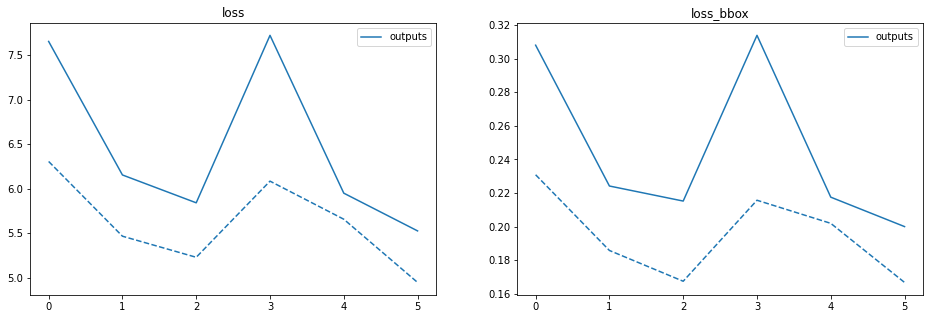

In [22]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path('outputs/')]

fields_of_interest = (
    'loss',
    'loss_bbox',
    )

plot_logs(log_directory,
          fields_of_interest)

In [23]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


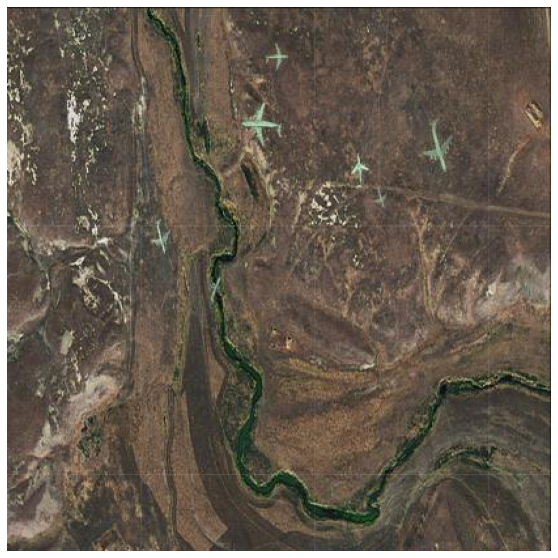

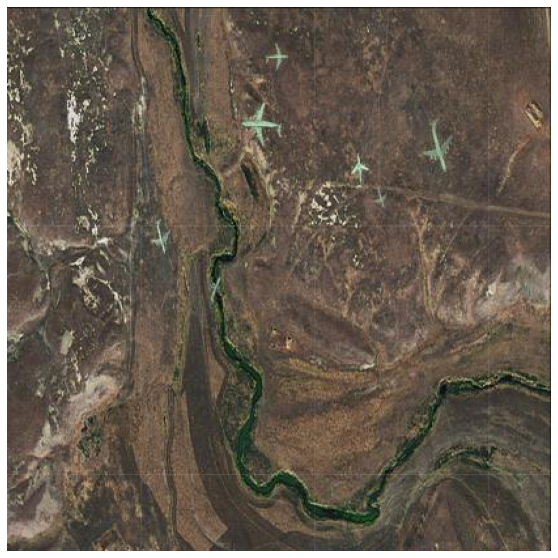

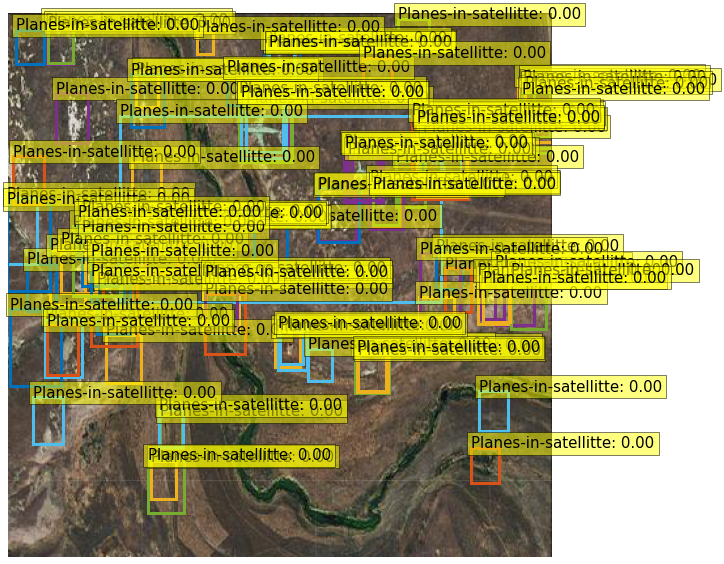

In [24]:
from PIL import Image

img_name = '/content/data/custom/val2017/img409_png.rf.e2e52948bab9cd80b829d48515d673b1.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)